<a target="_blank" href="https://colab.research.google.com/github/ramzan-basheer/Graph-Neural-Networks/blob/master/Node%20Classification%20with%20GNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Node Classification with Graph Neural Networks

<center><img src=https://imgs.search.brave.com/7L7HnDH6XNwidjkPapYJ4X8c2QvlwdThymMjA3D7PDY/rs:fit:1182:225:1/g:ce/aHR0cHM6Ly90c2U0/Lm1tLmJpbmcubmV0/L3RoP2lkPU9JUC53/bFowNFZBU2hSTkJ3/R09hWThWcXR3SGFD/LSZwaWQ9QXBp></center>

First let's install all the necessary packages

In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

%pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import matplotlib.pyplot as plt

1.13.1+cu117
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**TSNE** (t-distributed stochastic neighbor embedding) is a popular nonlinear dimensionality reduction technique often used for visualizing high-dimensional data in a low-dimensional space. It is particularly useful for visualizing embeddings learned from deep learning models. It works by constructing a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked, and then constructing a probability distribution over pairs of low-dimensional points such that the KL divergence between the two distributions is minimized. Finally, it optimizes the low-dimensional embeddings such that they reproduce the pairwise similarities in the high-dimensional space as closely as possible. The result is a set of low-dimensional points that can be plotted in two or three dimensions for easy visualization.

In [22]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

[Previous: Introduction: Hands-on Graph Neural Networks](https://github.com/ramzan-basheer/Graph-Neural-Networks/blob/master/Introduction-Graph%20Neural%20Networks.ipynb)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

The dataset provides the following information:

* `x`: a feature matrix of size `(num_nodes, num_features)` containing bag-of-words representations of the content of each document.
* `edge_index`: an edge index of size `(2, num_edges)` where `edge_index[0]` and `edge_index[1]` contain the indices of the start and end nodes of each edge, respectively.
* `y`: a class label for each node, represented as an integer between **0** and `num_classes-1`.
* `train_mask`: a binary mask of size `(num_nodes,)` that indicates which nodes should be used for training.
* `val_mask`: a binary mask of size `(num_nodes,)` that indicates which nodes should be used for validation.
* `test_mask`: a binary mask of size `(num_nodes,)` that indicates which nodes should be used for testing.

The `NormalizeFeatures` class in the `torch_geometric.transforms` module is used to normalize the node feature matrix of a graph dataset. Specifically, it normalizes the feature matrix by subtracting the mean and dividing by the standard deviation of each feature dimension across all nodes in the graph. Normalizing the node features can help improve the performance of machine learning models that operate on the graph, as it makes the features more comparable across different nodes and reduces the influence of outliers.

This code snippet loads the Cora dataset from the 'data/Planetoid' directory, normalizes its node features using the NormalizeFeatures transform, and returns a Data object containing the normalized graph and node labels.

The Planetoid class is used to load the Cora dataset, which is a citation network dataset consisting of 2,708 scientific publications classified into one of seven classes. Each publication is represented by a feature vector of 1433 dimensions, which includes binary values indicating the presence or absence of certain words in the publication. The task is to classify each publication into one of the seven categories based on its feature vector and citation links to other publications.

The resulting Data object contains the normalized feature matrix as `data.x`, the node labels as `data.y`, and the graph structure as `data.edge_index` (an edge index tensor in COO format). It can be used as input to various graph machine learning models in the PyTorch Geometric library.

In [9]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [10]:
from torch.nn import Linear
import torch.nn.functional as F

`torch.nn.functional` is a module in PyTorch that contains a large number of functions that are commonly used in neural network training and evaluation. These functions are designed to be used in conjunction with other PyTorch modules such as `torch.nn.Module`, which provides a way to define neural network layers and architectures.

Here are some examples of the kinds of functions you can find in `torch.nn.functional`:

* Activation functions such as `relu`, `sigmoid`, and `tanh`.
* Pooling operations such as `max_pool2d` and `avg_pool2d`.
* Loss functions such as `cross_entropy`, `mse_loss`, and `l1_loss`.
* Convolutional operations such as `conv2d` and `conv_transpose2d`.
* Normalization operations such as `batch_norm` and `instance_norm`.

* The `MLP` class extends `torch.nn.Module`, which is the base class for all PyTorch neural network modules.
* The constructor for the MLP class takes a single argument `hidden_channels`, which specifies the number of hidden units in the MLP. This value is used to define the sizes of the linear layers in the network.
* In the constructor, `super().__init__()` calls the constructor of the base class to initialize the module.
* The `torch.manual_seed(12345)` line sets the random seed for reproducibility.
* `self.lin1 = Linear(dataset.num_features, hidden_channels)` creates a Linear layer with `dataset.num_features` input channels and `hidden_channels` output channels. This layer performs a linear transformation of the input data, multiplying it by a weight matrix and adding a bias vector. `dataset.num_features` is the number of input features in the dataset.
* `self.lin2 = Linear(hidden_channels, dataset.num_classes)` creates another Linear layer that takes `hidden_channels` input channels and produces `dataset.num_classes` output channels. This layer produces the final output of the network, which is a probability distribution over the possible classes in the dataset.
* In the `forward` method, `x` is passed through the first linear layer with `x = self.lin1(x)`. The `relu` activation function is then applied to the output of this layer with `x = x.relu()`. This introduces nonlinearity into the model and allows it to learn more complex relationships between the input and output.
* `F.dropout(x, p=0.5, training=self.training)` applies dropout regularization to the output of the first layer with a dropout probability of **0.5**. Dropout randomly "drops out" a fraction of the units in the layer during training, which can prevent overfitting and improve generalization performance.
* The output of the first layer is then passed through the second linear layer with `x = self.lin2(x)`.
* Finally, the output of the second layer is returned as the output of the `forward` method with return `x`.

We define a simple two-layer MLP that takes an input vector, performs a linear transformation followed by a nonlinear activation function and dropout, and produces a probability distribution over the possible output classes.

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

Test Accuracy: 0.5900


As one can see, our MLP performs rather bad with only about 59% test accuracy. But why does the MLP do not perform better? The main reason for that is that this model suffers from heavy overfitting due to only having access to a small amount of training nodes, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: Cited papers are very likely related to the category of a document. That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.

## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://github.com/ramzan-basheer/Graph-Neural-Networks/blob/master/Introduction-Graph%20Neural%20Networks.ipynb), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [18]:
from torch_geometric.nn import GCNConv

`GCNConv` is a module in PyTorch Geometric (torch_geometric) library that implements the Graph Convolutional Network (GCN) layer. The `GCNConv` module applies a graph convolution operation on the input data using a specified number of filters (i.e., output channels) and a specified graph adjacency matrix.

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


This code defines a PyTorch module GCN that implements a two-layer Graph Convolutional Network (GCN) for node classification. The module takes as input a feature matrix x and an edge index matrix edge_index that define the graph structure.

The `__init__` function initializes the module and creates two `GCNConv` layers, each with a specified number of hidden channels. The first `GCNConv` layer takes as input the number of input features in the dataset and the number of hidden channels specified in the `hidden_channels` parameter. The second `GCNConv` layer takes as input the number of hidden channels and the number of classes in the dataset.

The `forward` function applies the two `GCNConv` layers in sequence to the input feature matrix and edge index matrix. Between the two `GCNConv` layers, the `relu` activation function is applied to the output of the first layer, and a `dropout` layer with a dropout rate of 0.5 is applied to the output of the activation function. The final output of the `forward` function is the result of applying the second `GCNConv` layer to the output of the dropout layer.

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

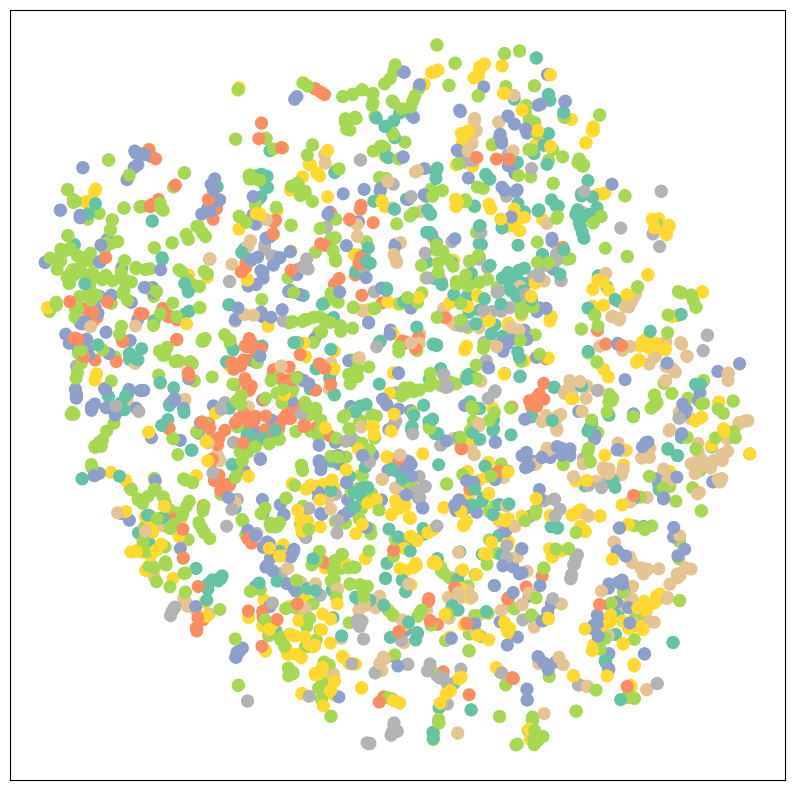

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


After training the model, we can check its test accuracy:

Test Accuracy: 0.8150


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.5% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

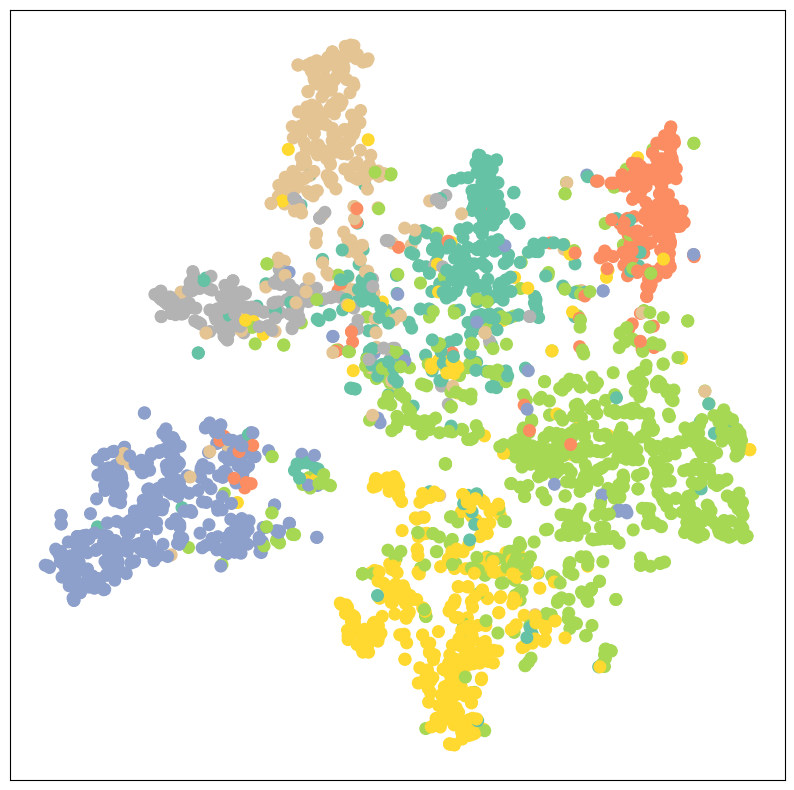

[Next: Graph Classification with Graph Neural Networks](https://github.com/ramzan-basheer/Graph-Neural-Networks/blob/master/Graph%20Classification%20with%20GNN.ipynb)